In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import joblib

# and IPython.display for audio output
from IPython.display import Audio
from scipy.io import wavfile
from scipy.linalg import hadamard

%matplotlib inline

# Functions

### Util functions

In [2]:
def plot_signal(rate, signal):
    N = signal.shape[0]
    T = N / rate
    print(f'Audio length: {T:.2f} seconds')
    
    x = np.arange(N) / rate
    
    f, ax = plt.subplots(figsize=(12, 6))
    ax.plot(x, signal)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Amplitude')

In [3]:
def plot_spectrum(band_1, band_2=None, label_1=None, label_2=None):
    if band_2 is not None and band_1.shape != band_2.shape:
        print(band_1.shape, band_2.shape)
        raise ValueError('band_1 and band_2 shapes must be equal!')
    
    N = band_1.shape[0]
    x = np.arange(N)
    
    f, ax = plt.subplots(figsize=(12, 6))
    line_1, = ax.plot(x, band_1)
    if label_1:
        line_1.set_label(label_1)
        
        ax.legend()
    
    if band_2 is not None:
        line_2, = ax.plot(x, band_2)
    
        if label_2:
            line_2.set_label(label_2)

        ax.legend()

In [4]:
def print_matrix(matrix, n_rows=None, n_cols=None):
    if not n_rows:
        n_rows = matrix.shape[0]
    if not n_cols:
        n_cols = matrix.shape[1]
        
    for l in range(n_rows):
        for k in range(n_cols):
            print(f'{matrix[l,k]:.0f}', end=' ')
        print()

### 1) Remove latent periods

In [5]:
def remove_latent_periods(s_1):
    # evaluate std
    std_1 = np.std(s_1)

    # evaluate U
    U = 1/3 * std_1
    
    # index of cut from the begining
    stop_1 = 0
    for i in range(len(s_1)):
        if not(-abs(U) < s_1[i] < abs(U)):
            stop_1 = i - 1
            break

    # index of cut from the end
    stop_2 = len(s_1)
    for i in range(len(s_1) - 1, -1, -1):
        if not(-abs(U) < s_1[i] < abs(U)):
            stop_2 = i - 1
            break

    # s with latent periods removed
    s_2 = s_1[stop_1:stop_2 + 1]
    
    return s_2

In [6]:
def normalize(s_2):
    # evaluate new std
    std_2 = np.std(s_2)

    # normalize s
    s_2 = s_2 / std_2
    
    return s_2

 ### 2) Spectral-band representation

#### Fourier transformation

In [7]:
def furier_transformation(s_2):
    N_harmonic = 256
    
    N_2 = s_2.shape[0]
    
    rows = N_2 // N_harmonic
    S_w_t = np.zeros((rows, N_harmonic))

    for l in range(rows):
        starting_index = l * N_harmonic
        for k in range(N_harmonic):
            a, b = 0, 0
            for i in range(N_harmonic):
                a += s_2[starting_index + i] * np.sin(2 * np.pi * k * i / N_harmonic)
                b += s_2[starting_index + i] * np.cos(2 * np.pi * k * i / N_harmonic)

            a *= 2 / N_harmonic
            b *= 2 / N_harmonic

            c_squared = a ** 2 + b ** 2

            S_w_t[l, k] = c_squared
    
    # return only first half of each harmonic because of symmetry
    return S_w_t[:, :N_harmonic // 2]

#### Walsh transformation

In [8]:
def walsh_transformation(s_2):
    N_harmonic = 256

    A = hadamard(N_harmonic)
    
    N_2 = s_2.shape[0]
    
    rows = N_2 // N_harmonic
    S_w_t = np.zeros((rows, N_harmonic))
    for l in range(rows):
        starting_index = l * N_harmonic
        for k in range(N_harmonic):
            val = np.dot(
                s_2[starting_index:starting_index+N_harmonic], A[:,k]
            )
            S_w_t[l, k] = val
    
    return S_w_t

#### Spectral-band representation

In [9]:
def spectral_band_representation(S_w_t): 
    S_w_t = S_w_t.T

    S = np.zeros((9, S_w_t.shape[1]))
    S[0] = np.sqrt(S_w_t[0,:] ** 2 + S_w_t[1,:] ** 2)
    S[1] = np.sqrt(S_w_t[2,:] ** 2 + S_w_t[3,:] ** 2)
    S[2] = np.sqrt(S_w_t[4,:] ** 2 + S_w_t[5,:] ** 2)
    S[3] = np.sqrt(S_w_t[6,:] ** 2 + S_w_t[7,:] ** 2)
    S[4] = np.sqrt(S_w_t[8,:] ** 2 + S_w_t[9,:] ** 2)
    S[5] = np.sqrt(
        np.sum(
            S_w_t[i,:] ** 2 for i in range(10, 15)
        )
    )
    S[6] = np.sqrt(
        np.sum(
            S_w_t[i,:] ** 2 for i in range(15, 25)
        )
    )
    S[7] = np.sqrt(
        np.sum(
            S_w_t[i,:] ** 2 for i in range(25, 50)
        )
    )
    S[8] = np.sqrt(
        np.sum(
            S_w_t[i,:] ** 2 for i in range(50, S_w_t.shape[0])
        )
    )
    
    return S

### 3) Low-frequency filtration

In [10]:
def low_frequency_filtration(S, f, l):
    S_new = np.zeros(S.shape)
    
    for i in range(S.shape[0]):
        for n in range(S.shape[1]):
            tmp = S[i].copy()
            y = 0
            for k in range(-l, l+1):
                if k == 0:
                    c = 2 * f
                else:
                    c = 1 / (k * np.pi) * np.sin(2 * np.pi * k * f)

                if n - k < 0:
                    y += c * S[i][0]
                elif n - k >= len(S[i]):
                    y += c * S[i][-1]
                else:
                    y += c * S[i][n-k]
            S_new[i,n] = y
    
    return S_new

### 4) Dynamic programming

In [11]:
def euclidean(v1, v2):
    """Returns the Euclidean distance between equal-length vectors"""
    return np.sqrt(
        np.sum((v1 - v2) ** 2)
    )

def hamming(v1, v2):
    """Returns the Hamming distance between equal-length vectors"""
    if len(v1) != len(v2):
        raise ValueError("Undefined for sequences of unequal length")
    return sum(np.fabs(x1 - x2) for x1,x2 in zip(v1, v2))

In [12]:
def distance(matrix_1, matrix_2, d=euclidean):
    cols_1 = matrix_1.shape[1]
    cols_2 = matrix_2.shape[1]
    
    D = np.zeros((cols_1, cols_2))
    
    for i in range(cols_1):
        for j in range(cols_2):
            D[i][j] = d(matrix_1[:,i], matrix_2[:,j])
    
    D_new = D.copy()
    for i in range(0, D.shape[0]):
        for j in range(0, D.shape[1]):
            if i == j == 0:
                continue
                
            candidates = []
            if i > 0 and j > 0:
                candidates.append(D_new[i-1][j-1])
            if i > 0:
                candidates.append(D_new[i-1][j])
            if j > 0:
                candidates.append(D_new[i][j-1])
            
            D_new[i][j] = min(candidates) + D_new[i][j]
    
    n_steps = 0
    i,j = D.shape[0] - 1, D.shape[1] - 1
    while i != 0 and j != 0:
        n_steps += 1
        
        candidates = []
        if i > 0 and j > 0:
            candidates.append(
                [D_new[i-1,j-1], i-1, j-1]
            )
        if i > 0:
            candidates.append(
                [D_new[i-1][j], i-1, j]
            )
        if j > 0:
            candidates.append(
                [D_new[i][j-1], i, j-1]
            )
        i, j = min(candidates, key=lambda arr: arr[0])[1:]
    
    return D_new[-1, -1] / n_steps

# Testing

In [13]:
AUDIO_DIR = 'SOUND'

audio_files = sorted(
    file_name for file_name in os.listdir(AUDIO_DIR) if file_name.lower().endswith('.wav')
)

### 1) Choose file

In [14]:
file_chooser = widgets.RadioButtons(
    options=audio_files,
    description='File name:'
)

In [15]:
file_chooser

RadioButtons(description='File name:', options=('0.WAV', '00.WAV', '01.WAV', '02.WAV', '03.WAV', '04.WAV', '05.WAV', '06.WAV', '07.WAV', '08.WAV', '09.WAV', '1.WAV', '2.WAV', '3.WAV', '4.WAV', '5.WAV', '6.WAV', '7.WAV', '8.WAV', '9.WAV'), value='0.WAV')

In [16]:
chosen_file_name = file_chooser.value

In [17]:
rate, s_1 = wavfile.read(os.path.join(AUDIO_DIR, chosen_file_name))

print(f'Length of s_1 = {s_1.shape[0]} \nSampling rate = {rate}')

Length of s_1 = 15329 
Sampling rate = 22050


In [18]:
Audio(data=s_1, rate=rate)

Audio length: 0.70 seconds


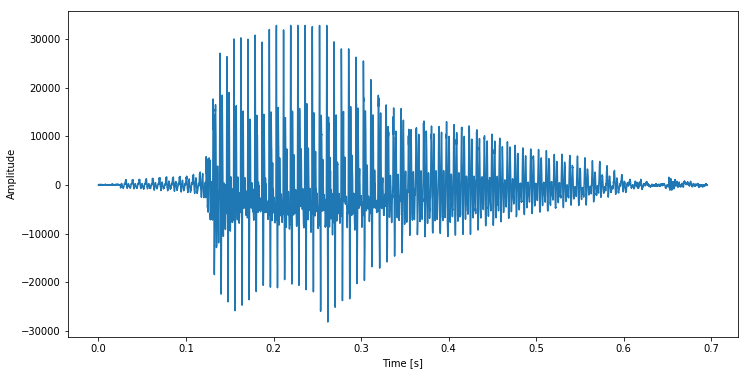

In [19]:
plot_signal(rate, s_1)

### 2) Remove latent periods

Audio length: 0.49 seconds


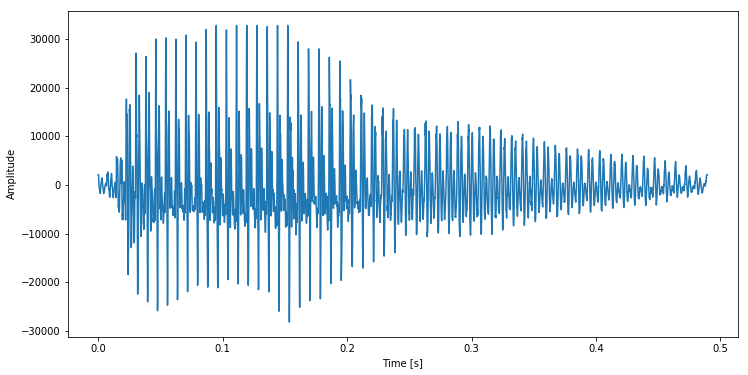

In [20]:
s_2 = remove_latent_periods(s_1)

plot_signal(rate, s_2)

### 3) Normalize signal

Audio length: 0.49 seconds


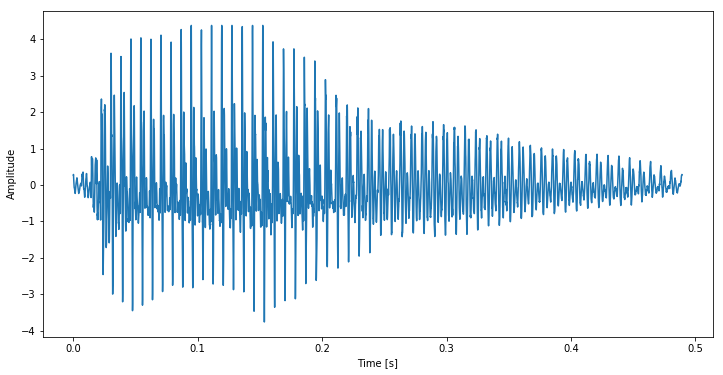

In [21]:
s_2 = normalize(s_2)

plot_signal(rate, s_2)

In [22]:
Audio(data=s_2, rate=rate)

### 4) Perform transformation transformation

In [23]:
transformation_chooser = widgets.RadioButtons(
    options=['Furier', 'Walsh'],
    description='Transformation:',
    style={'description_width': 'initial'}
)

In [24]:
transformation_chooser

RadioButtons(description='Transformation:', options=('Furier', 'Walsh'), style=DescriptionStyle(description_width='initial'), value='Furier')

In [25]:
t = transformation_chooser.value
transformation = furier_transformation if t == 'Furier' else walsh_transformation

In [26]:
S_w_t = transformation(s_2)

In [27]:
@widgets.interact(row_number=(0, S_w_t.shape[0]-1))
def f(row_number=0):
    plot_spectrum(S_w_t[row_number])

interactive(children=(IntSlider(value=0, description='row_number', max=41), Output()), _dom_classes=('widget-interact',))

### 5) Create spectral-band representation and low frequency filtration

In [28]:
S = spectral_band_representation(S_w_t)

In [29]:
f = 0.2
l = 5

S_new = low_frequency_filtration(S, f, l)

In [30]:
@widgets.interact(band=(0, S.shape[0]-1))
def f(band=0):
    plot_spectrum(band_1=S[band], band_2=S_new[band], label_1='Band', label_2='Filtered band')

interactive(children=(IntSlider(value=0, description='band', max=8), Output()), _dom_classes=('widget-interact',))

In [31]:
audio_files_data = {}

cache = f'cache_{transformation.__name__}.pkl'

if os.path.exists(cache):
    audio_files_data = joblib.load(cache)
else:
    for audio_file_name in audio_files:
        path = os.path.join(AUDIO_DIR, audio_file_name)
        rate, s_1 = wavfile.read(path)
        s_2 = remove_latent_periods(s_1)
        s_2 = normalize(s_2)

        S_w_t = transformation(s_2)

        S = spectral_band_representation(S_w_t)

        f = 0.2
        l = 5
        S_filtered = low_frequency_filtration(S, f, l)

        audio_files_data[audio_file_name] = S_filtered
    
    joblib.dump(audio_files_data, cache)

In [32]:
results = []
for file_name, matrix in audio_files_data.items():
    results.append([
        file_name, distance(S_new, matrix, d=euclidean)
    ])

results.sort(key=lambda pair: pair[1])
print('File name \t Distance')
for file_name, d in results:
    print(f'  {file_name} \t {d:.2f}')

File name 	 Distance
  0.WAV 	 0.00
  2.WAV 	 0.38
  00.WAV 	 0.41
  3.WAV 	 0.45
  5.WAV 	 0.46
  03.WAV 	 0.54
  02.WAV 	 0.58
  08.WAV 	 0.68
  9.WAV 	 0.68
  6.WAV 	 0.69
  07.WAV 	 0.71
  05.WAV 	 0.74
  8.WAV 	 0.78
  09.WAV 	 0.83
  01.WAV 	 0.84
  1.WAV 	 0.85
  7.WAV 	 0.92
  06.WAV 	 1.16
  04.WAV 	 1.19
  4.WAV 	 1.36
